# Error correction models - ERRIS

## About this document

This document was generated from an R markdown file on `r as.character(Sys.time())`.

[Li, Ming; Wang, QJ; Bennett, James; Robertson, David. Error reduction and representation in stages (ERRIS) in hydrological modelling for ensemble streamflow forecasting. Hydrology and Earth System Sciences. 2016; 20:3561-3579. https://doi.org/10.5194/hess-20-3561-2016 ](https://doi.org/10.5194/hess-20-3561-2016)

## Calibrating ERRIS

### Model structure

We use sample hourly data from the Adelaide catchment [this catchment in the Northern Territory, TBC](https://en.wikipedia.org/wiki/Adelaide_River). The catchment model set up is not the key point of this vignette so we do not comment on that section: 

In [1]:
from swift2.vis import OptimisationPlots
import xarray as xr
import pandas as pd
import numpy as np
import xarray as xr

In [2]:
import swift2

In [3]:
# Only temporary, under construction...
import swift2.wrap.swift_wrap_generated as swg
import swift2.wrap.swift_wrap_custom as swc

In [4]:
from swift2.doc_helper import *

from swift2.system import *
from swift2.simulation import *
from swift2.play_record import *
from swift2.utils import *
from swift2.parameteriser import *
from swift2.statistics import *
# from swift2.prototypes import extractOptimizationLog
from swift2.model_definitions import *

from uchronia.time_series import get_item, mk_date



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from cinterop.timeseries import TIME_DIMNAME, slice_xr_time_series, pd_series_to_xr_series, slice_xr_time_series, pd_series_to_xr_series

In [7]:
from cinterop.timeseries import xr_ts_start, xr_ts_end
import datetime as dt

In [8]:
%matplotlib inline

In [9]:
catchmentStructure = sample_catchment_model(site_id= "Adelaide", config_id="catchment")

hydromodel = "GR4J";
channel_routing = 'MuskingumNonLinear';
hydroModelRainfallId = 'P'
hydroModelEvapId = 'E'

from swift2.classes import HypercubeParameteriser, Parameteriser, Simulation

In [10]:
# set models
insimulation = swap_model(catchmentStructure, model_id= hydromodel ,what = "runoff")
simulation:Simulation = swap_model(insimulation, model_id = channel_routing ,what = "channel_routing")

saId = get_subarea_ids(simulation)

In [11]:
saId = saId[0] # HACK: need to test robustness to different time series passed to player functions

precipTs = sample_series(site_id = "Adelaide", var_name= "rain")
evapTs = sample_series(site_id = "Adelaide", var_name = "evap")
flowRateTs = sample_series(site_id = "Adelaide", var_name = "flow")

play_input(simulation, precipTs, mk_full_data_id('subarea', saId, hydroModelRainfallId))
play_input(simulation, evapTs, mk_full_data_id('subarea', saId, hydroModelEvapId))
configure_hourly_gr4j(simulation)
set_simulation_time_step(simulation, 'hourly')

# Small time interval only, to reduce runtimes in this vignette
simstart = mk_date(2010,12,1)  
simend = mk_date(2011,6,30,23)  
simwarmup = simstart

set_simulation_span(simulation, simstart, simend)

In [12]:
flowRateTs

2007-01-01 00:00:00      NaN
2007-01-01 01:00:00      NaN
2007-01-01 02:00:00      NaN
2007-01-01 03:00:00      NaN
2007-01-01 04:00:00      NaN
                       ...  
2014-12-04 17:00:00    0.435
2014-12-04 18:00:00    0.424
2014-12-04 19:00:00    0.414
2014-12-04 20:00:00    0.405
2014-12-04 21:00:00    0.397
Length: 69478, dtype: float64

In [13]:
get_state_value(simulation, "subarea.1.areaKm2")
# getCatchmentStructure(simulation)

{'subarea.1.areaKm2': 638.0}

In [14]:
get_state_value(catchmentStructure, "subarea.1.areaKm2")

{'subarea.1.areaKm2': 638.0}

In [15]:
def templateHydroParameterizer(simulation):
    return define_parameteriser_gr4j_muskingum(ref_area=250.0,
        time_span=3600,
        simulation=simulation,
        objfun="NSE",
        delta_t=1.0,
        param_name_k='Alpha')

nodeId = 'node.2'
flowId = mk_full_data_id(nodeId, 'OutflowRate')

record_state(simulation, flowId)

We use pre-calibrated hydrologic parameters (reproducible with doc/error_correction_doc_preparation.r in this package structure) 

In [16]:
p = templateHydroParameterizer(simulation)
set_min_parameter_value(p, 'R0', 0.0)
set_max_parameter_value(p, 'R0', 1.0)
set_min_parameter_value(p, 'S0', 0.0)
set_max_parameter_value(p, 'S0', 1.0)
set_parameter_value( p, 'log_x4', 1.017730e+00)
set_parameter_value( p, 'log_x1', 2.071974e+00	)
set_parameter_value( p, 'log_x3', 1.797909e+00	)
set_parameter_value( p, 'asinh_x2', -1.653842e+00)	
set_parameter_value( p, 'R0', 2.201930e-11	)
set_parameter_value( p, 'S0', 3.104968e-11	)
set_parameter_value( p, 'X', 6.595537e-03	) # Gotcha: needs to be set before alpha is changed.
set_parameter_value( p, 'Alpha', 6.670534e-01	)
p.as_dataframe()

    
sViz = mk_date(2010,12,1)
eViz = mk_date(2011,4,30,23)

def one_wet_season(tts):
    from cinterop.timeseries import ts_window
    return ts_window(tts, from_date=sViz, to_date=eViz) 

def plot_obs_vs_calc(obs, calc, ylab="flow (m3/s)"):
    from swift2.vis import plot_two_series
    obs = as_xarray_series(one_wet_season(obs))
    calc = one_wet_season(calc)
    plot_two_series(obs, calc, start_time= xr_ts_start(obs), end_time= xr_ts_end(obs))

In [17]:
p.apply_sys_config(simulation)

In [18]:
simulation.exec_simulation()

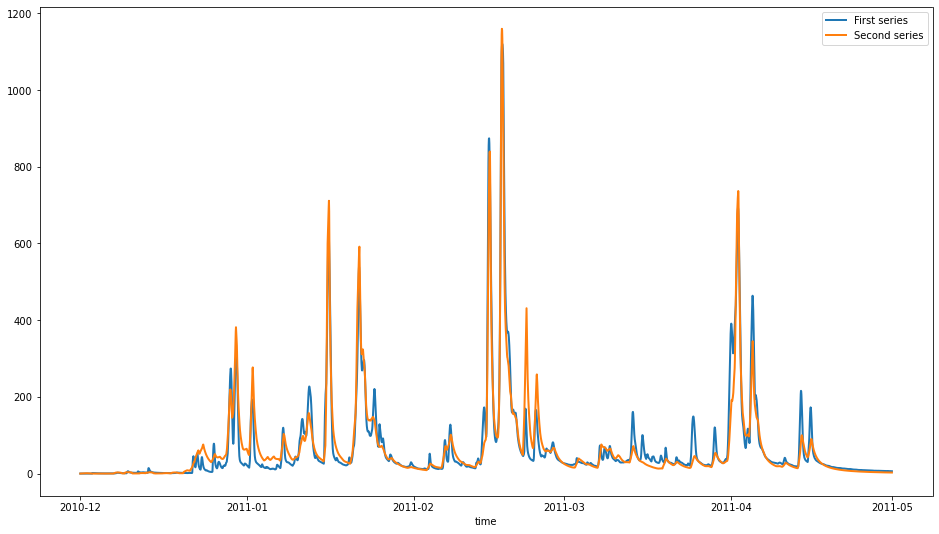

In [19]:
plot_obs_vs_calc(flowRateTs, simulation.get_recorded(flowId))

In [20]:
flowRateTs

2007-01-01 00:00:00      NaN
2007-01-01 01:00:00      NaN
2007-01-01 02:00:00      NaN
2007-01-01 03:00:00      NaN
2007-01-01 04:00:00      NaN
                       ...  
2014-12-04 17:00:00    0.435
2014-12-04 18:00:00    0.424
2014-12-04 19:00:00    0.414
2014-12-04 20:00:00    0.405
2014-12-04 21:00:00    0.397
Length: 69478, dtype: float64

### Set up the error correction model

In [21]:
simulation.get_node_ids(), simulation.get_node_names()

(['2', '1'], ['Outlet', 'Node_1'])

In [22]:
errorModelElementId = 'node.2';
simulation.set_error_correction_model('ERRIS', errorModelElementId, length=-1, seed=0)

flowRateTsGapped = flowRateTs

In [23]:
flowRateTsGapped['2011-02'] = np.nan

# plot(flowRateTsGapped)

play_input(simulation,flowRateTsGapped,var_ids=mk_full_data_id(errorModelElementId,"ec","Observation"))

Now, prepare a model with error correction, and set up for generation

In [24]:
from swift2.prototypes import *

ecs = simulation.clone()

ecs.set_state_value(mk_full_data_id(nodeId,"ec","Generating"),False)
updatedFlowVarID = mk_full_data_id(nodeId,"ec","Updated")
inputFlowVarID = mk_full_data_id(nodeId,"ec","Input")
ecs.record_state(var_ids=c(updatedFlowVarID, inputFlowVarID))

### ERRIS calibration in stages

In [25]:
#termination = getMaxRuntimeTermination(0.005)
termination = create_sce_termination_wila('relative standard deviation', c('0.05','0.0167'))

We could set up a four-stages estimation in one go, but we will instead work in each stages for didactic purposes.

In [26]:
%%time 
censOpt = 0.0
estimator = create_erris_parameter_estimator (simulation, flowRateTs, errorModelElementId,
                                            estimation_start = simstart, estimation_end=simend, cens_thr=0.0, cens_opt=censOpt,
                                            termination_condition=termination, restriction_on=True, weighted_least_square=False)

stageOnePset = swg.CalibrateERRISStageOne_py(estimator)
print(stageOnePset.as_dataframe())

              Name        Value     Min     Max
0          Epsilon    -7.972797   -20.0     0.0
1           Lambda    -0.935233   -30.0     5.0
2                D     0.000000     0.0     0.0
3               Mu     0.000000     0.0     0.0
4              Rho     0.000000     0.0     0.0
5   Sigma1_Falling     0.000000     0.0     0.0
6    Sigma1_Rising     0.000000     0.0     0.0
7   Sigma2_Falling     0.000000     0.0     0.0
8    Sigma2_Rising     0.000000     0.0     0.0
9   Weight_Falling     1.000000     1.0     1.0
10   Weight_Rising     1.000000     1.0     1.0
11         CensThr     0.000000     0.0     0.0
12         CensOpt     0.000000     0.0     0.0
13          MaxObs  1126.300000  1126.3  1126.3
CPU times: user 3.9 s, sys: 7.3 ms, total: 3.9 s
Wall time: 3.91 s


#### Stage 2

Stage two can be logged:

In [27]:
%%time 
swg.SetERRISVerboseCalibration_py(estimator, True)
stageTwoPset = swg.CalibrateERRISStageTwo_py(estimator, stageOnePset)
print(stageTwoPset.as_dataframe())

              Name        Value          Min          Max
0                D     0.747785     0.000000     2.000000
1               Mu    -1.648841  -100.000000   100.000000
2    Sigma1_Rising     0.349269    -6.907755     6.907755
3          CensOpt     0.000000     0.000000     0.000000
4          CensThr     0.000000     0.000000     0.000000
5          Epsilon    -7.972797    -7.972797    -7.972797
6           Lambda    -0.935233    -0.935233    -0.935233
7           MaxObs  1126.300000  1126.300000  1126.300000
8              Rho     0.000000     0.000000     0.000000
9   Sigma1_Falling     0.000000     0.000000     0.000000
10  Sigma2_Falling     0.000000     0.000000     0.000000
11   Sigma2_Rising     0.000000     0.000000     0.000000
12  Weight_Falling     1.000000     1.000000     1.000000
13   Weight_Rising     1.000000     1.000000     1.000000
CPU times: user 8.83 s, sys: 405 ms, total: 9.23 s
Wall time: 9.24 s


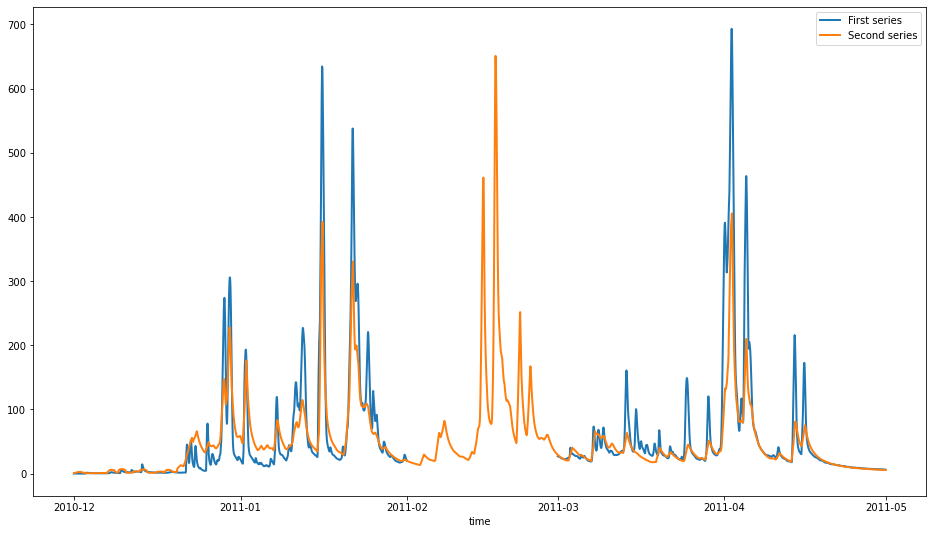

In [28]:
def mkEcIds(p:HypercubeParameteriser) -> HypercubeParameteriser:
    df = p.as_dataframe()
    df.Name = mk_full_data_id(nodeId, 'ec', df.Name)
    return create_parameteriser('Generic',df)

mkEcIds(stageTwoPset).apply_sys_config(ecs)
ecs.exec_simulation()
plot_obs_vs_calc(flowRateTsGapped, ecs.get_recorded(updatedFlowVarID))

A helper function to process the calibration log:

In [29]:
# def prepOptimLog(estimator, fitness_name = "Log.likelihood"):
#     optimLog = getLoggerContent(estimator)
#     # head(optimLog)
#     # optimLog$PointNumber = 1:nrow(optimLog)   
#     logMh = mkOptimLog(optimLog, fitness = fitness_name, messages = "Message", categories = "Category") 
#     geom_ops = mhplot::subset_by_message(logMh)
#     d = list(data=logMh, geom_ops=geom_ops)
# }

In [30]:
type(estimator), str(estimator)

(swift2.classes.ErrisStagedCalibration,
 'CFFI pointer handle to a native pointer of type id "ERRIS_STAGED_CALIBRATION_PTR"')

In [31]:
opt_log = estimator.extract_optimisation_log(fitness_name = "Log-likelihood")

In [32]:
geom_ops = opt_log['geom_ops'] 

In [33]:
def get_max_ll(): return np.max(geom_ops._data["Log-likelihood"])

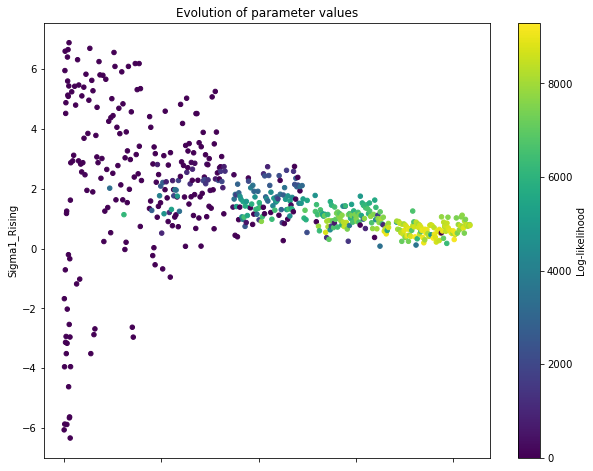

In [34]:
v = OptimisationPlots(geom_ops)
g = v.parameter_evolution('Sigma1_Rising', c(0, get_max_ll()))
plt.gcf().set_size_inches(10,8)

#### Stage 3

In [35]:
%%time
stageThreePset = swg.CalibrateERRISStageThree_py(estimator, stageTwoPset)
print(stageThreePset.as_dataframe())

              Name        Value          Min          Max
0              Rho     0.977261     0.000000     1.000000
1    Sigma1_Rising    -1.613140    -6.907755     6.907755
2          CensOpt     0.000000     0.000000     0.000000
3          CensThr     0.000000     0.000000     0.000000
4                D     0.747785     0.747785     0.747785
5          Epsilon    -7.972797    -7.972797    -7.972797
6           Lambda    -0.935233    -0.935233    -0.935233
7           MaxObs  1126.300000  1126.300000  1126.300000
8               Mu    -1.648841    -1.648841    -1.648841
9   Sigma1_Falling     0.000000     0.000000     0.000000
10  Sigma2_Falling     0.000000     0.000000     0.000000
11   Sigma2_Rising     0.000000     0.000000     0.000000
12  Weight_Falling     1.000000     1.000000     1.000000
13   Weight_Rising     1.000000     1.000000     1.000000
CPU times: user 2.14 s, sys: 21.4 ms, total: 2.16 s
Wall time: 2.13 s


In [36]:
opt_log = estimator.extract_optimisation_log(fitness_name = "Log-likelihood")

In [37]:
geom_ops = opt_log['geom_ops'] 

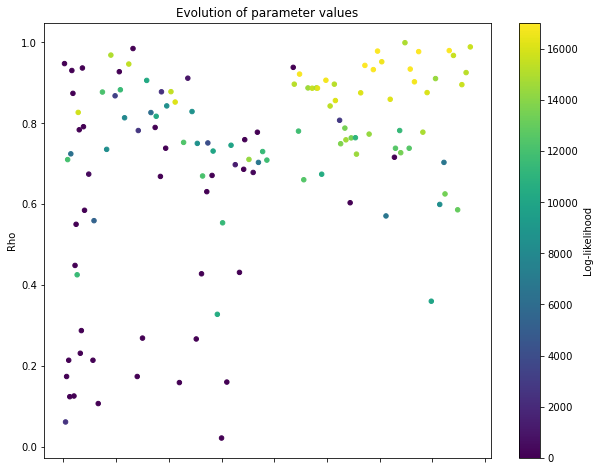

In [38]:
v = OptimisationPlots(geom_ops)
g = v.parameter_evolution('Rho', c(0, get_max_ll()))
plt.gcf().set_size_inches(10,8)

#### Stage 3a, generating and fitting M and S if free

In [39]:
%%time
stageThreePsetMS = swg.CalibrateERRISStageThreeMS_py(estimator, stageThreePset)
print(stageThreePsetMS.as_dataframe())

              Name        Value          Min          Max
0              Rho     0.977261     0.000000     1.000000
1    Sigma1_Rising    -1.613140    -6.907755     6.907755
2          CensOpt     0.000000     0.000000     0.000000
3          CensThr     0.000000     0.000000     0.000000
4                D     0.747785     0.747785     0.747785
5          Epsilon    -7.972797    -7.972797    -7.972797
6           Lambda    -0.935233    -0.935233    -0.935233
7           MaxObs  1126.300000  1126.300000  1126.300000
8               Mu    -1.648841    -1.648841    -1.648841
9   Sigma1_Falling     0.000000     0.000000     0.000000
10  Sigma2_Falling     0.000000     0.000000     0.000000
11   Sigma2_Rising     0.000000     0.000000     0.000000
12  Weight_Falling     1.000000     1.000000     1.000000
13   Weight_Rising     1.000000     1.000000     1.000000
14          MNoise    -0.802462  -100.000000   100.000000
15          SNoise     1.948928   -10.000000    10.000000
CPU times: use

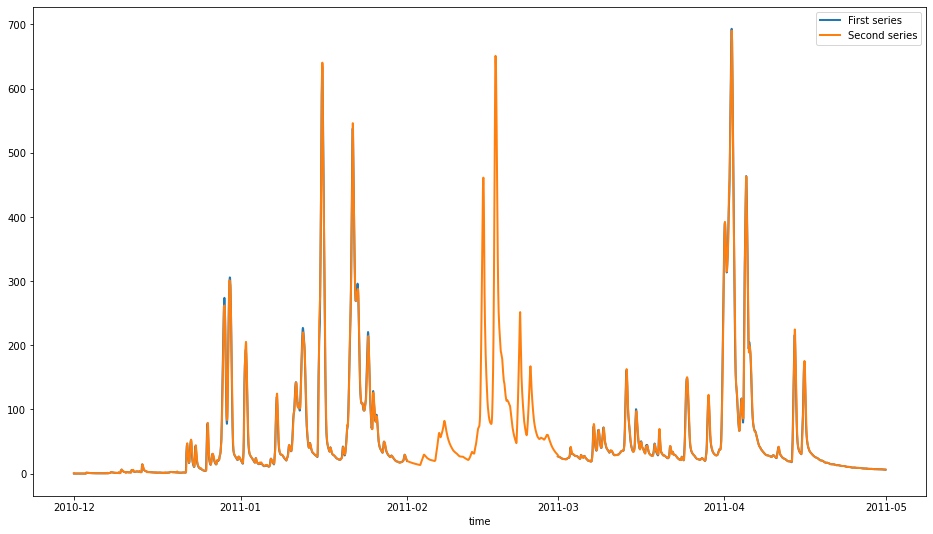

In [40]:
mkEcIds(stageThreePsetMS).apply_sys_config(ecs)
ecs.exec_simulation()
plot_obs_vs_calc(flowRateTsGapped, ecs.get_recorded(updatedFlowVarID))

#### Stage 4, rising limb 

In [41]:
%%time
stageFourPsetRising = swg.CalibrateERRISStageFour_py(estimator, stageThreePsetMS, useRising = True)
print(stageFourPsetRising.as_dataframe())

              Name        Value          Min          Max
0    Sigma1_Rising    -1.725378    -6.907755     6.907755
1    Sigma2_Rising     0.086763    -6.907755     6.907755
2    Weight_Rising     0.853421     0.500000     1.000000
3          CensOpt     0.000000     0.000000     0.000000
4          CensThr     0.000000     0.000000     0.000000
5                D     0.747785     0.747785     0.747785
6          Epsilon    -7.972797    -7.972797    -7.972797
7           Lambda    -0.935233    -0.935233    -0.935233
8           MaxObs  1126.300000  1126.300000  1126.300000
9               Mu    -1.648841    -1.648841    -1.648841
10             Rho     0.977261     0.977261     0.977261
11  Sigma1_Falling     0.000000     0.000000     0.000000
12  Sigma2_Falling     0.000000     0.000000     0.000000
13  Weight_Falling     1.000000     1.000000     1.000000
CPU times: user 2.4 s, sys: 28.2 ms, total: 2.43 s
Wall time: 2.39 s


In [42]:
opt_log = estimator.extract_optimisation_log(fitness_name = "Log-likelihood")

In [43]:
geom_ops = opt_log['geom_ops'] 

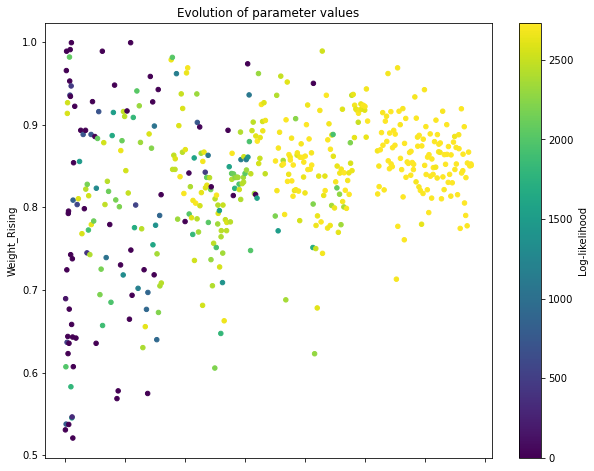

In [44]:
v = OptimisationPlots(geom_ops)
g = v.parameter_evolution('Weight_Rising', c(0, get_max_ll()))
plt.gcf().set_size_inches(10,8)

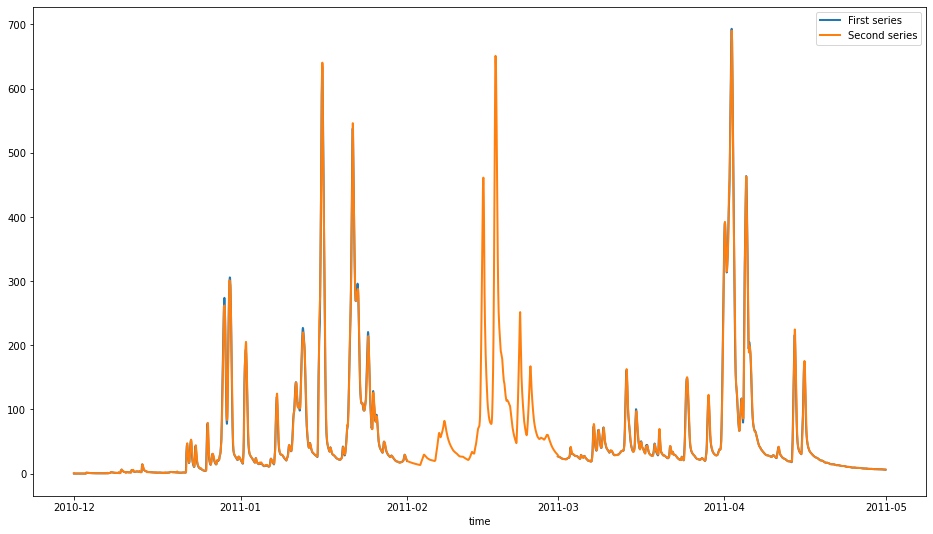

In [45]:
mkEcIds(stageFourPsetRising).apply_sys_config(ecs)
ecs.exec_simulation()
plot_obs_vs_calc(flowRateTsGapped, ecs.get_recorded(updatedFlowVarID))

#### Stage 4, falling limbs

In [46]:
%%time
stageFourPsetFalling = swg.CalibrateERRISStageFour_py(estimator, stageThreePsetMS, useRising = False)
print(stageFourPsetFalling.as_dataframe())

              Name        Value          Min          Max
0    Sigma1_Rising    -3.675723    -6.907755     6.907755
1    Sigma2_Rising    -1.198708    -6.907755     6.907755
2    Weight_Rising     0.794993     0.500000     1.000000
3          CensOpt     0.000000     0.000000     0.000000
4          CensThr     0.000000     0.000000     0.000000
5                D     0.747785     0.747785     0.747785
6          Epsilon    -7.972797    -7.972797    -7.972797
7           Lambda    -0.935233    -0.935233    -0.935233
8           MaxObs  1126.300000  1126.300000  1126.300000
9               Mu    -1.648841    -1.648841    -1.648841
10             Rho     0.977261     0.977261     0.977261
11  Sigma1_Falling     0.000000     0.000000     0.000000
12  Sigma2_Falling     0.000000     0.000000     0.000000
13  Weight_Falling     1.000000     1.000000     1.000000
CPU times: user 30 s, sys: 44.6 ms, total: 30 s
Wall time: 30 s


In [47]:
opt_log = estimator.extract_optimisation_log(fitness_name = "Log-likelihood")

In [48]:
geom_ops = opt_log['geom_ops'] 

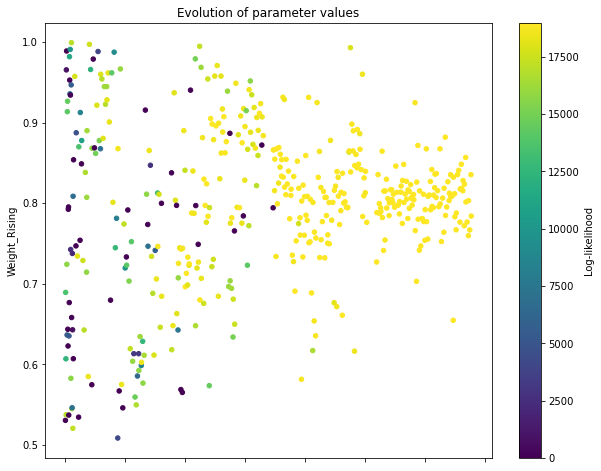

In [49]:
v = OptimisationPlots(geom_ops)
g = v.parameter_evolution('Weight_Rising', c(0, get_max_ll()))
plt.gcf().set_size_inches(10,8)

#### Final consolidated parameter set

In [50]:
finalPset = swg.ConcatenateERRISStagesParameters_py(estimator, hydroParams = create_parameteriser(), stage1_result =  stageOnePset, stage2_result = stageTwoPset, 
                                   stage3_result = stageThreePsetMS, stage4a_result = stageFourPsetRising, stage4b_result = stageFourPsetFalling, toLongParameterName = False)

print(finalPset.as_dataframe())

              Name        Value          Min          Max
0          CensThr     0.000000     0.000000     0.000000
1          CensOpt     0.000000     0.000000     0.000000
2           MNoise    -0.802462  -100.000000   100.000000
3           SNoise     1.948928   -10.000000    10.000000
4           Lambda    -0.935233    -0.935233    -0.935233
5          Epsilon    -7.972797    -7.972797    -7.972797
6               Mu    -1.648841    -1.648841    -1.648841
7                D     0.747785     0.747785     0.747785
8              Rho     0.977261     0.977261     0.977261
9           MaxObs  1126.300000  1126.300000  1126.300000
10   Sigma1_Rising    -1.725378    -6.907755     6.907755
11   Sigma2_Rising     0.086763    -6.907755     6.907755
12   Weight_Rising     0.853421     0.500000     1.000000
13  Sigma1_Falling    -3.675723    -6.907755     6.907755
14  Sigma2_Falling    -1.198708    -6.907755     6.907755
15  Weight_Falling     0.794993     0.500000     1.000000


### Legacy call

Check that the previous "one stop shop" call gives the same results.

In [51]:
%%time

censOpt = 0.0
termination = create_sce_termination_wila('relative standard deviation', c('0.05','0.0167'))

dummyDate = simstart

from swift2.prototypes import estimate_erris_parameters

psetFullEstimate = estimate_erris_parameters(simulation, flowRateTs, errorModelElementId,
  warmup_start=dummyDate, warmup_end=dummyDate, warmup=False, estimation_start = simstart, estimation_end=simend, cens_thr=0.0,
 cens_opt = censOpt, exclusion_start=dummyDate, exclusion_end=dummyDate, exclusion=False, termination_condition = termination,
  hydro_params = None, erris_params = None, restriction_on = True,
  weighted_least_square = False)

print(psetFullEstimate.as_dataframe())

                        Name        Value          Min          Max
0          node.2.ec.CensThr     0.000000     0.000000     0.000000
1          node.2.ec.CensOpt     0.000000     0.000000     0.000000
2           node.2.ec.MNoise    -0.802462  -100.000000   100.000000
3           node.2.ec.SNoise     1.948928   -10.000000    10.000000
4           node.2.ec.Lambda    -0.935233    -0.935233    -0.935233
5          node.2.ec.Epsilon    -7.972797    -7.972797    -7.972797
6               node.2.ec.Mu    -1.648841    -1.648841    -1.648841
7                node.2.ec.D     0.747785     0.747785     0.747785
8              node.2.ec.Rho     0.977261     0.977261     0.977261
9           node.2.ec.MaxObs  1126.300000  1126.300000  1126.300000
10   node.2.ec.Sigma1_Rising    -1.725378    -6.907755     6.907755
11   node.2.ec.Sigma2_Rising     0.086763    -6.907755     6.907755
12   node.2.ec.Weight_Rising     0.853421     0.500000     1.000000
13  node.2.ec.Sigma1_Falling    -3.675723    -6.